In [2]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
offense = pd.read_csv('data/offense.csv', index_col=0)
defense = pd.read_csv('data/defense.csv', index_col=0)
salary = pd.read_csv('data/salary.csv', index_col=0)
salary.columns = ['Team', 'Year'] + list(salary.columns[2:])
standings = pd.read_csv('data/standings.csv', index_col = 0)

In [4]:
combined = pd.merge(offense, defense, on=['Team', 'Year'], suffixes=('_off', '_def'))
combined = pd.merge(combined, salary, on=['Team', 'Year'])
combined.columns

Index(['Team', 'Year', 'Yds/G_rush_off', 'TD_rush_off', 'Yds/G_pass_off',
       'Pct_off', 'TD_pass_off', 'Sck_off', 'Rate_off', 'Pts/G_off',
       'Pen Yds_off', 'TO', 'Yds/G_rush_def', 'TD_rush_def', 'Yds/G_pass_def',
       'TD_pass_def', 'Rate_def', 'Sck_def', 'Pct_def', 'Pts/G_def',
       'Pen Yds_def', 'DL', 'LB', 'OL', 'QB', 'RB', 'S', 'ST', 'TE', 'WR',
       'nDL', 'nLB', 'nOL', 'nQB', 'nRB', 'nS', 'nST', 'nTE', 'nWR'],
      dtype='object')

In [5]:
pp.ProfileReport(combined)

Number of variables,39
Number of observations,160
Total Missing (%),0.0%
Total size in memory,50.0 KiB
Average record size in memory,320.0 B
Numeric,38
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


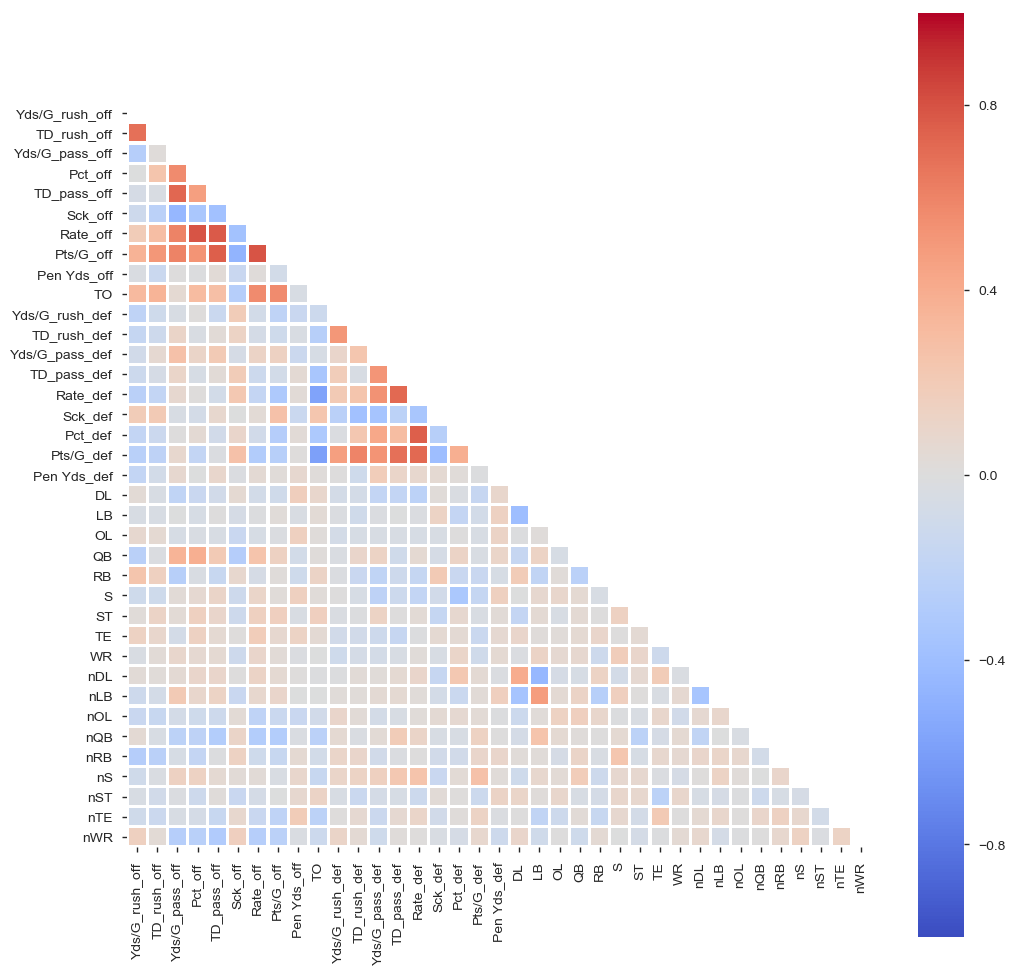

In [14]:
corr = combined[combined.columns[2:]].corr()

import seaborn as sns
from matplotlib.colors import ListedColormap

labels = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
labels = labels.replace(np.nan,' ', regex=True)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

mask = np.triu(np.ones(corr.shape)).astype(np.bool)

_ = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap='coolwarm', square=True, ax=ax)

mask = np.ones((37, 37))-mask

_ = sns.heatmap(corr, mask=mask, cmap=ListedColormap(['white']),cbar=False, fmt='', 
                annot=corr.columns, linewidths=1.5, ax=ax)

In [12]:
mask.shape

(37, 37)